# Integrantes do grupo


*   Antônio Caetano Neves Neto
*   Beatriz Reis Gama Barbosa
*   João Lucas Simões Moreira





In [48]:
import numpy as np
import networkx as nx
import matplotlib.animation
import matplotlib.pyplot as plt
import plotly.graph_objects as go

Número de vértices: 20


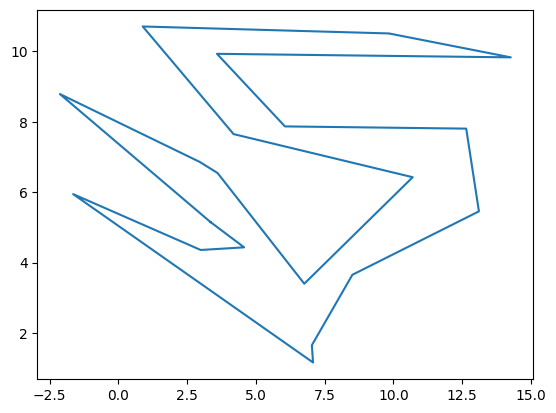

In [40]:
filename = 'poligonos/teste.pol'
coordinates = []
X = []
Y = []

with open(filename, 'r') as file:
  text = file.read()
  try:
    words = text.split("\n")
    qtd = int(words[0])

    for i in range(qtd):
      x, y, nil = words[i+1].split(' ')
      x1, x2 = x.split('/')
      y1, y2 = y.split('/')
      x = float(x1)/float(x2)
      y = float(y1)/float(y2)
      X.append(x)
      Y.append(y)
      coordinates.append((x,y))
  except:
    #try:
      words = text.split(" ")
      qtd = int(words[0])

      for i in range(qtd):
        x, y = words[i*2+1], words[i*2+2]

        x1, x2 = x.split('/')
        y1, y2 = y.split('/')
        x = float(x1)/float(x2)
        y = float(y1)/float(y2)
        X.append(x)
        Y.append(y)
        coordinates.append((x,y))
    #except:
      # raise Exception("N conheço essa entrada, perdão.")

print(f"Número de vértices: {len(coordinates)}")
plt.plot(X + [X[0]], Y + [Y[0]])
plt.show()

In [41]:
def is_convex(a, b, c):
  return (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0]) >= 0

def is_in_triangle(a, b, c, p):
	L = [0, 0, 0]
	eps = 0.0000001

	L[0] = ((b[1] - c[1]) * (p[0] - c[0]) + (c[0] - b[0]) * (p[1] - c[1])) \
		  /(((b[1] - c[1]) * (a[0] - c[0]) + (c[0] - b[0]) * (a[1] - c[1])) + eps)
	L[1] = ((c[1] - a[1]) * (p[0] - c[0]) + (a[0] - c[0]) * (p[1] - c[1])) \
		  /(((b[1] - c[1]) * (a[0] - c[0]) + (c[0] - b[0]) * (a[1] - c[1])) + eps)
	L[2] = 1 - L[0] - L[1]

	for x in L:
		if x > 1 or x < 0:
			return False
	return True

def get_unique_ear(polygon, n_frames):
  s = len(polygon)
  frames = []

  if s < 3:
    return [], [], frames, n_frames

  if s == 3:
    return (polygon[0][0], polygon[1][0], polygon[2][0]), (polygon[0][1], polygon[1][1], polygon[2][1]), frames, n_frames

  for i in range(s):
    p1, p2, p3 = polygon[(i-1) % s][0], polygon[i % s][0], polygon[(i+1) % s][0]
    pi1, pi2, pi3 = polygon[(i-1) % s][1], polygon[i % s][1], polygon[(i+1) % s][1]

    frames.append(
      go.Frame(data=[
          go.Scatter(
              x=[point[0] for point in coordinates] + [coordinates[0][0]],
              y=[point[1] for point in coordinates] + [coordinates[0][1]],
              name="Polygon"
            ),
          go.Scatter(
              x=np.concatenate(triangles_plot_x).tolist(),
              y=np.concatenate(triangles_plot_y).tolist(),
              name="Triangles"
          ),
          go.Scatter(
            x=[p1[0]] + [p2[0]] + [p3[0]] + [p1[0]],
            y=[p1[1]] + [p2[1]] + [p3[1]] + [p1[1]],
            fill="toself",
            line=dict(color="rgba(200, 200, 0, 1)"),
            fillcolor="rgba(200, 200, 0, 0.5)",
            name="Current Triangle"
        )],
        name=f"frame_{n_frames}"
    ))

    n_frames += 1

    if is_convex(p1, p2, p3):
      if not any([not (p in (p1, p2, p3)) and is_in_triangle(p1, p2, p3, p) for p in coordinates]):
        del polygon[i % s]
        return (p1, p2, p3), (pi1, pi2, pi3), frames, n_frames

  return [], [], frames, n_frames


def is_clock_wise(polygon):
  sum = (polygon[0][0] - polygon[len(polygon)-1][0]) * (polygon[0][1] + polygon[len(polygon)-1][1])

  for i in range(len(polygon)-1):
	  sum += (polygon[i+1][0] - polygon[i][0]) * (polygon[i+1][1] + polygon[i][1])

  return sum > 0

In [42]:
triangles = []
triangles_index = []
# Queremos também além dos pontos qual o index respectivo dos mesmos
polygon = coordinates[::-1] if is_clock_wise(coordinates) else coordinates[:]
polygon = [(p, i) for i, p in enumerate(polygon)]

frames = []

n_frames = 0

triangles_plot_x = [[]]
triangles_plot_y = [[]]

while len(polygon) > 3:
  t, t_index, crr_frames, n_frames = get_unique_ear(polygon, n_frames)
  if t == []: break

  frames += crr_frames

  frame = go.Frame(data=
      [
          go.Scatter(
              x=[point[0] for point in coordinates] + [coordinates[0][0]],
              y=[point[1] for point in coordinates] + [coordinates[0][1]],
              name="Polygon"
            ),
          go.Scatter(
              x=np.concatenate(triangles_plot_x).tolist(),
              y=np.concatenate(triangles_plot_y).tolist(),
              name="Triangles",
              fill="toself",
              fillcolor="rgba(255, 0, 0, 0.5)"
          ),
          go.Scatter(
            x=[point[0] for point in t] + [t[0][0]],
            y=[point[1] for point in t] + [t[0][1]],
            fill="toself",
            name="Current Triangle",
            line=dict(color="rgba(0, 255, 0, 1)"),
            fillcolor="rgba(0, 255, 0, 0.5)"
          )
      ],
      name=f"frame_{n_frames}"
  )
  n_frames += 1

  triangles.append(t)
  frames.append(frame)
  triangles_index.append(t_index)
  triangles_plot_x.append([p[0] for p in t] + [t[0][0]] + [None])
  triangles_plot_y.append([p[1] for p in t] + [t[0][1]] + [None])


t, t_index, _, n_frames = get_unique_ear(polygon, n_frames)

frames.append(
    go.Frame(data=
      [
          go.Scatter(
              x=[point[0] for point in coordinates] + [coordinates[0][0]],
              y=[point[1] for point in coordinates] + [coordinates[0][1]],
              name="Polygon"
            ),
          go.Scatter(
              x=np.concatenate(triangles_plot_x).tolist(),
              y=np.concatenate(triangles_plot_y).tolist(),
              name="Triangles"
          ),
          go.Scatter(
            x=[point[0] for point in t] + [t[0][0]],
            y=[point[1] for point in t] + [t[0][1]],
            fill="toself",
            name="Current Triangle",
            line=dict(color="rgba(0, 255, 0, 1)"),
            fillcolor="rgba(0, 255, 0, 0.5)"
          )
      ],
      name=f"frame_{n_frames}"
  )
)

triangles.append(t)
triangles_index.append(t_index)

fig = go.Figure(
    data=[
        go.Scatter(
              x=[point[0] for point in coordinates] + [coordinates[0][0]],
              y=[point[1] for point in coordinates] + [coordinates[0][1]],
              name="Polygon"
            ),
        go.Scatter(x=[0, 0], y=[0, 0], name="Triangles"),
        go.Scatter(x=[0, 0], y=[0, 0], name="Current Triangle")
    ],
    layout=go.Layout(
        xaxis=dict(range=[min(X)-10, max(X)+10], autorange=False),
        yaxis=dict(range=[min(Y)-10, max(Y)+10], autorange=False),
        title="Ear Cliping - Execution",
        updatemenus = [dict(
          buttons = [
              dict(
                  args = [None, {"frame": {"duration": 1000/len(coordinates), "redraw": True},
                                  "fromcurrent": True}],
                  label = "Play",
                  method = "animate"
                  ),
              dict(
                  args = [[None], {"frame": {"duration": 0, "redraw": False},
                                    "mode": "immediate",
                                    "transition": {"duration": 0}}],
                  label = "Pause",
                  method = "animate"
                  ),
              dict(
                label="Slow",
                method="animate",
                args=[
                    None,
                    dict(frame=dict(duration=500, redraw=True), fromcurrent=True, transition=dict(duration=0))
                ],
                execute=None
            )
          ],
      )]
    ),
    frames=frames,
)

sliders = [dict(steps=[dict(method='animate',
                              args= [[f'frame_{k}'],
                              dict(mode= 'immediate',
                                   frame= dict(duration=2000/len(coordinates), redraw=True),
                                   transition=dict(duration= 0))
                                 ],
                              label=f'Slide {k+1}'
                             ) for k in range(0, len(frames), 20)],
                active=0,
                transition= dict(duration=0),
                currentvalue=dict(font=dict(size=12),
                                  visible=True,
                                  xanchor= 'center'
                                 ),
                len=1.0)
           ]

fig.update_layout(width=1200, height=800, sliders=sliders)

fig.show()

In [43]:
def CommonVertex(a, b):
  set_a, set_b = set(a), set(b)
  common_items = set_a & set_b
  return len(common_items)

def TriangleAdjList(triangles):
  adj_list = []
  for _ in range(len(triangles)):
    adj_list.append([])

  for idx, cur_triangle in enumerate(triangles):
    for jdx, alt_triangle in enumerate(triangles):
      if alt_triangle == cur_triangle:
        continue
      if CommonVertex(cur_triangle, alt_triangle) == 2:
        adj_list[idx].append(jdx)

  return adj_list

def ThreeColoring(triangle):
  cur_colors = set([0, 1, 2, 3]) - set([colors[triangle[0]], colors[triangle[1]], colors[triangle[2]]])
  if cur_colors == set([1, 2, 3]):
    colors[triangle[0]], colors[triangle[1]], colors[triangle[2]] = [1, 2, 3]
  for vertex in triangle:
    colors[vertex] = cur_colors.pop() if colors[vertex] == 0 else colors[vertex]

time = 0
def DFS(visited, graph, node, timestamps):
  global time
  if node not in visited:
    ThreeColoring(triangles_index[node])
    time += 1
    timestamps[node][0] = time
    visited.add(node)
    for neighbour in graph[node]:
      DFS(visited, graph, neighbour, timestamps)
    time += 1
    timestamps[node][1] = time

visited = set()
timestamps = [[np.int64(0), np.int64(0)] for _ in range(len(triangles_index))]
colors = np.int64(np.zeros(len(triangles_index) + 2))
triangles_adj_list = TriangleAdjList(triangles_index)
DFS(visited, triangles_adj_list, 0, timestamps)
print(timestamps)

[[1, 36], [6, 7], [5, 8], [4, 9], [13, 14], [20, 21], [19, 22], [18, 23], [17, 24], [16, 25], [15, 26], [12, 27], [11, 28], [10, 29], [3, 30], [2, 35], [31, 34], [32, 33]]


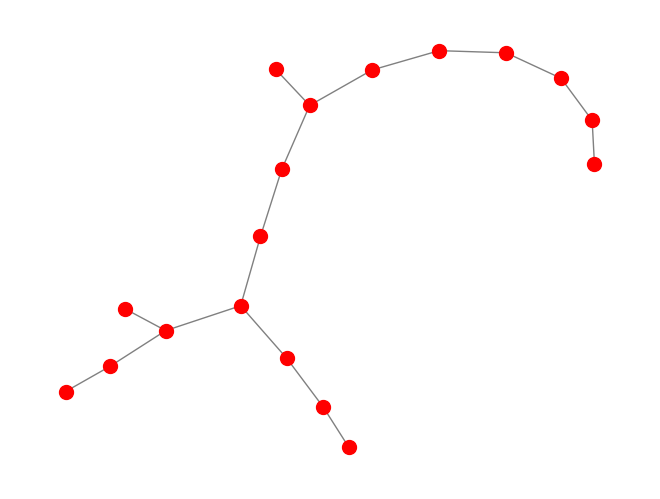

In [44]:
G = nx.Graph()
adj_list = TriangleAdjList(triangles_index)
for idx, neighbours in enumerate(adj_list):
  for neighbour in neighbours:
    G.add_edge(idx, neighbour)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_color='red', node_size=100, edge_color='gray', font_size=0, font_weight='bold')
plt.show()

In [45]:
pos = nx.spring_layout(G)

fig, ax = plt.subplots(figsize=(8, 6))

def get_colors(i):
    white = [idx for idx, time in enumerate(timestamps) if time[0] > i]
    gray = [idx for idx, time in enumerate(timestamps) if time[0] <= i and time[1] > i]
    black = [idx for idx, time in enumerate(timestamps) if time[1] <= i]
    return white, gray, black


def update(num):
    ax.clear()

    # draw nodes with correct color
    white, gray, black = get_colors(num)
    white_nodes = nx.draw_networkx_nodes(G, pos=pos, nodelist=white, node_color="white", ax=ax)
    white_nodes.set_edgecolor("black")
    gray_nodes = nx.draw_networkx_nodes(G, pos=pos, nodelist=gray, node_color="gray", ax=ax)
    gray_nodes.set_edgecolor("black")
    black_nodes = nx.draw_networkx_nodes(G, pos=pos, nodelist=black, node_color="black", ax=ax)
    black_nodes.set_edgecolor("white")

    nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color="gray")
    # nx.draw_networkx_labels(G, pos=pos, labels=dict(zip(current_path, current_path)), font_color="white", ax=ax)

    ax.set_title(f"DFS: Passo {num}", fontweight="bold")
    ax.set_xticks([])
    ax.set_yticks([])


ani = matplotlib.animation.FuncAnimation(fig, update, frames=timestamps[0][1]+1, interval=1000, repeat=True)
ani.save("dfs.gif")
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


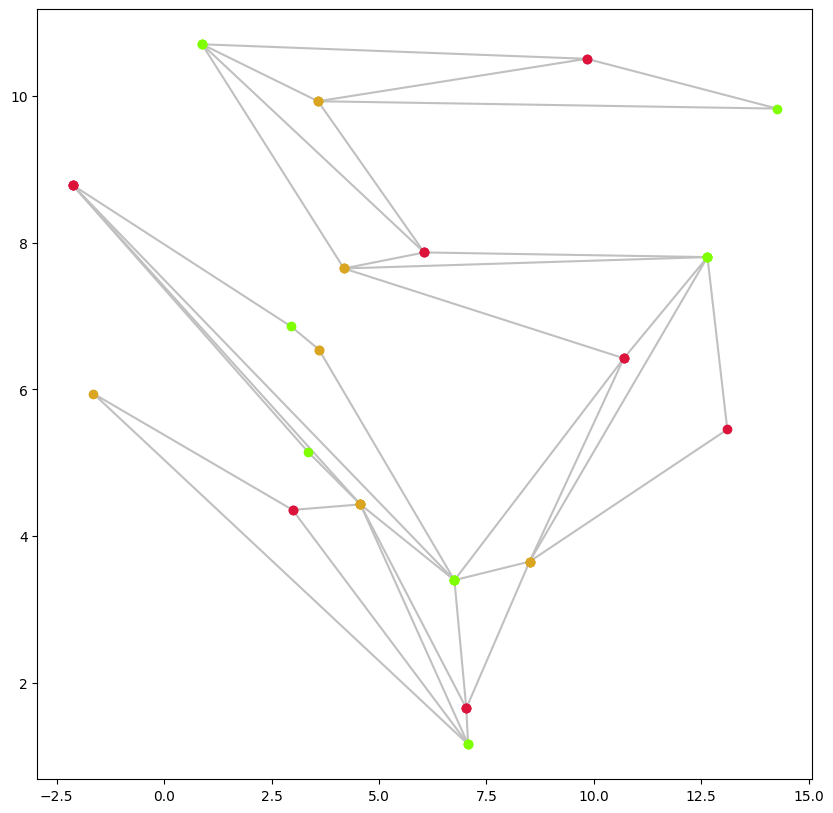

In [51]:
labels_colors = {
    1: 'crimson',
    2: 'chartreuse',
    3: 'goldenrod'
}

plt.figure(figsize=(10, 10))  
for idx, triangle in enumerate(triangles):
  x, y, z = triangle
  i, j, k = triangles_index[idx][0], triangles_index[idx][1], triangles_index[idx][2]

  plt.scatter(x[0], x[1], color = labels_colors[colors[i]], zorder=2)
  plt.scatter(y[0], y[1], color = labels_colors[colors[j]], zorder=2)
  plt.scatter(z[0], z[1], color = labels_colors[colors[k]], zorder=2)
  plt.plot([x[0], y[0], z[0]], [x[1], y[1], z[1]], color = "silver", zorder=1)
plt.show()  



In [52]:
# Dicionário para armazenar as cores dos pontos já coloridos
previous_colors = {}

fig, ax = plt.subplots(figsize=(10, 10))

def update(idx):
    ax.clear()  
    triangle = triangles[idx]
    x, y, z = triangle
    i, j, k = triangles_index[idx][0], triangles_index[idx][1], triangles_index[idx][2]

    for _, other_triangle in enumerate(triangles):
        if triangle == other_triangle:
            continue
        a, b, c = other_triangle
        ax.scatter(a[0], a[1], color=previous_colors.get(tuple(a), "black"), zorder=2)
        ax.scatter(b[0], b[1], color=previous_colors.get(tuple(b), "black"), zorder=2)
        ax.scatter(c[0], c[1], color=previous_colors.get(tuple(c), "black"), zorder=2)
        ax.plot([a[0], b[0], c[0], a[0]], [a[1], b[1], c[1], a[1]], color="silver", zorder=1)

    current_color_x = labels_colors[colors[i]]
    current_color_y = labels_colors[colors[j]]
    current_color_z = labels_colors[colors[k]]

    previous_colors[tuple(x)] = current_color_x
    previous_colors[tuple(y)] = current_color_y
    previous_colors[tuple(z)] = current_color_z

    ax.scatter(x[0], x[1], color=current_color_x, zorder=2)
    ax.scatter(y[0], y[1], color=current_color_y, zorder=2)
    ax.scatter(z[0], z[1], color=current_color_z, zorder=2)
    ax.plot([x[0], y[0], z[0], x[0]], [x[1], y[1], z[1], x[1]], color="black", zorder=1)
    
    ax.set_title(f"Coloração: Passo {idx}", fontweight="bold")

# Cria a animação
ani = matplotlib.animation.FuncAnimation(fig, update, frames=len(triangles), repeat=True, interval=1000)

# Salva a animação como um arquivo GIF
ani.save('coloracao.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.
